In [1]:

from scipy.optimize import minimize

import numpy as np
import torch
import os

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_3, default, caloclouds_2_v3


from pointcloud.utils.metadata import Metadata
from pointcloud.utils import detector_map
from pointcloud.data.read_write import read_raw_regaxes, get_n_events
from pointcloud.data.conditioning import read_raw_regaxes_withcond

# imports specific to this evaluation
from pointcloud.evaluation.bin_standard_metrics import (
    conditioned_sample_model,
    sample_accumulator,
    get_wish_models,
    get_fish_models,
    get_caloclouds_models,
)
from pointcloud.evaluation.calculate_scale_factors import construct_dsf, get_path, DetectorScaleFactors

redo = True
# Gather the models to evaluate
# the dict has the format {model_name: (model, shower_flow, config)}
# the config should hold correct hyperparameters for the model,
# but the dataset_path may be incorrect.
models = {}
log_base = "../point-cloud-diffusion-logs/"
# log_base = "/beegfs/desy/user/dayhallh/point-cloud-diffusion-logs/"
log_base = "/data/dust/user/dayhallh/point-cloud-diffusion-logs"
# data_base = "../point-cloud-diffusion-data/"
# data_base = "/beegfs/desy/user/dayhallh/point-cloud-diffusion-data/"
data_base = "/data/dust/user/dayhallh/point-cloud-diffusion-data/"
torch.set_default_dtype(torch.float32)

static_dataset = "/data/dust/user/dayhallh/data/ILCsoftEvents/highGran_g40_p22_th90_ph90_en10-100.hdf5"
static_n_files = 10


angular_dataset = caloclouds_3_simple_shower.Configs().dataset_path
angular_n_files = caloclouds_3_simple_shower.Configs().n_dataset_files


try:
    pass
#    wish_path = os.path.join(
#        log_base, "wish/dataset_accumulators/p22_th90_ph90_en10-1/try2_wish_poly{}.pt"
#    )
#    models.update(
#        get_wish_models(
#            wish_path=wish_path,
#            n_poly_degrees=4,
#        )
#    )
except FileNotFoundError as e:
    print("Wish models not found")
    print(e)

try:
    pass
#    fish_path = os.path.join(
#        log_base, "wish/fish/fish.npz"
#    )
#    models.update(
#        get_fish_models(fish_path=fish_path)
#    )
except FileNotFoundError as e:
    print("Wish models not found")
    print(e)
try:
    pass
    if True:  # new a1 model
        config = caloclouds_3_simple_shower.Configs()
        config.device = 'cpu'
        config.cond_features = 4
        config.diffusion_pointwise_hidden_l1 = 32
        config.distillation = True
        config.cond_features_names = ["energy", "p_norm_local"]
        caloclouds_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt"]
        #showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth"]
        showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"]


        caloclouds = get_caloclouds_models(
            caloclouds_paths=caloclouds_paths, showerflow_paths=showerflow_paths, caloclouds_names=["CaloClouds3"], showerflow_names=["ShowerFlow_a1_fnorms_2"],
            config=config
        )

        dataset_stats = np.load("/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/stats.npz")
        #cc3_stats = np.load(showerflow_paths[0].replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"))

        # generate some custom metadata that will allow comparison between this model and the old model
        train_dataset_meta = Metadata(caloclouds_3_simple_shower.Configs())
        meta_here = Metadata(caloclouds_2_v3.Configs())

        meta_here.incident_rescale = 127
        meta_here.n_pts_rescale = train_dataset_meta.n_pts_rescale
        meta_here.vis_eng_rescale = 3.5

       # try as in interance
        #meta_here.mean_cog[:] = [-4.06743696e-03, -2.27790998e-01,  1.10137465e+01]
        meta_here.mean_cog[:] = [-4.06743696e-03, 0.321829,  1.10137465e+01]
        meta_here.std_cog[:] = [1.24559791, 0.95357278, 2.59475371]

        meta_here.log_incident_mean = train_dataset_meta.log_incident_mean
        meta_here.log_incident_std = train_dataset_meta.log_incident_std
        meta_here.found_attrs += ["log_incident_mean", "log_incident_std"]

        # internally, showers are assumed to be scaled between 0 and 1
        # but in cc3, they are actually normalised to std=0.5 mean=0
        # so we can alter Zmax_global, Zmin_global, Xmax_global and Xmin_global
        # to get the scaling needed
        Xmean, Ymean, Zmean = -0.0074305227, -0.21205868, 12.359252
        Xstd, Ystd, Zstd = 22.4728036, 23.65837968, 5.305082

        #meta_here.Xmax_global = Ymean
        #meta_here.Xmin_global = 2*Ystd - Ymean
        #meta_here.Zmax_global = Xmean
        #meta_here.Zmin_global = 2*Xstd - Xmean
        meta_here.Xmax_global = 2*Ymean
        meta_here.Xmin_global = 2*(2*Ystd - Ymean)
        meta_here.Zmax_global = 2*Xmean
        meta_here.Zmin_global = 2*(2*Xstd - Xmean)

    
        print('\n~~~~~~~~\n')
        print(repr(meta_here))
        print('\n~~~~~~~~\n')

        caloclouds["CaloClouds3-ShowerFlow_a1_fnorms_2"][2].metadata = meta_here

        models.update(caloclouds)

    if False:  #  old model, angular dataset
        config = caloclouds_3.Configs()
        config.device = 'cpu'
        config.cond_features = 4
        config.cond_features_names = ["energy", "p_norm_local"]
        parts = [
           "original_nb10_inputs36893488147419103231"
        ]
        showerflow_paths = [
           os.path.join(data_base, "showerFlow/sim-E1261AT600AP180-180",
           f"ShowerFlow_{part}_best.pth")
           for part in parts
        ]

        caloclouds = get_caloclouds_models(
            caloclouds_paths=[caloclouds_path], showerflow_paths=showerflow_paths, caloclouds_names=["CaloClouds3"], showerflow_names=[f"ShowerFlow_original_{i}" for i in [10]],
            config=config
        )
        models.update(caloclouds)

    if True:
        config = caloclouds_2_v3.Configs()
        config.device = 'cpu'
        config.cond_features = 2  # number of conditioning features (i.e. energy+points=2)
        config.cond_features_names = ["energy", "points"]
        config.shower_flow_cond_features = ["energy"]
        config.n_dataset_files = static_n_files
        config.dataset_path_in_storage = False
        config.dataset_path = static_dataset
        config.shower_flow_roll_xyz = True
        config.distillation = True
        #config.max_points = 6_000
        #config.max_points = 30_000
        #showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/220714_cog_e_layer_ShowerFlow_best.pth"]
        showerflow_paths = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_best.pth"]
        showerflow_paths = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_best.pth"]
        showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/220714_cog_e_layer_ShowerFlow_best.pth"]

        caloclouds_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/ckpt_0.000000_1000000.pt"]


        caloclouds = get_caloclouds_models(
            caloclouds_paths=caloclouds_paths, showerflow_paths=showerflow_paths, caloclouds_names=["CaloClouds2"], showerflow_names=["ShowerFlow_CC2"],
            config=config
        )

        #cc2_stats = np.load(showerflow_paths[0].replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"))

        train_dataset_meta = Metadata(config)
        #meta_here = Metadata(caloclouds_2.Configs())
        meta_here = Metadata(config)
        #meta_here.n_pts_rescale = 5000
        #meta_here.vis_eng_rescale = 2.5
        #meta_here.incident_rescale = 100
        #meta_here.std_cog = 1/cc2_stats["cog_x_std"], 1/cc2_stats["cog_y_std"], 1/cc2_stats["cog_z_std"]
        #meta_here.mean_cog = -cc2_stats["cog_x_mean"], -cc2_stats["cog_y_mean"], -cc2_stats["cog_z_mean"]
        #meta_here.mean_cog[:] = [0.3842599999999834, 0, 0.12772120012000343]
        #meta_here.std_cog[:] = [4.864242154098466**2, 1, 3.2035606359259203**2]

        print('\n~~~~~~~~\n')
        print("CC2")
        print(repr(meta_here))
        print(caloclouds["CaloClouds2-ShowerFlow_CC2"][2].max_points)
        print('\n~~~~~~~~\n')

        caloclouds["CaloClouds2-ShowerFlow_CC2"][2].metadata = meta_here

        models.update(caloclouds)
except FileNotFoundError as e:
    print("CaloClouds models not found")
    print(e)


config = caloclouds_3_simple_shower.Configs()
config.device = 'cpu'
config.dataset_path_in_storage = False
config._dataset_path = static_dataset
config.n_dataset_files = static_n_files
#config._dataset_path = angular_dataset
#config.n_dataset_files = angular_n_files
config.dataset_tag = "p22_th90_ph90_en10-100"
#config.dataset_tag = "sim-E1261AT600AP180-180"
model_name = "CaloClouds2-ShowerFlow_CC2"
save_name = get_path(config, model_name)
if os.path.exists(save_name):
    dsf = DetectorScaleFactors.load(save_name)
    print("Loaded")
else:
    print("Constructing")
    dsf = construct_dsf(config, model_name, models[model_name][2], models[model_name][0], models[model_name][1])
    dsf.save(save_name)

model_name_2 = 'CaloClouds3-ShowerFlow_a1_fnorms_2'
save_name_2 = get_path(config, model_name_2)
if os.path.exists(save_name_2):
    dsf_2 = DetectorScaleFactors.load(save_name_2)
    print("Loaded")
else:
    print("Constructing")
    dsf_2 = construct_dsf(config, model_name_2, models[model_name_2][2], models[model_name_2][0], models[model_name_2][1])
    dsf_2.save(save_name_2)


/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth

~~~~~~~~

Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/highGran_g40_p22_th90_ph90_en10-100_seed42_all_steps.hdf5
layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047
 1976.70495605 1988.15002441 1993.375      2004.81994629 2010.04504395]
half_cell_size_global: 2.5441665649414062
cell_thickness_global: 0.525024414

In [2]:


def plot_sample(dsf, model_name, n_samples, sample_n_coeff, sample_e_coeff=None, fake_n_coeff=None):
    mean_sq_n, mean_sq_e = dsf.divergance(n_samples, sample_n_coeff, sample_e_coeff, fake_n_coeff)
    cond_energies = dsf.cond["energy"][dsf.cond_idxs]
    g4_n = dsf.g4_detector_n[dsf.cond_idxs]
    g4_e = dsf.g4_detector_e[dsf.cond_idxs]
    
    from matplotlib import pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    scatter_args = dict(alpha=0.5)
    axs[0].set_ylabel("Active cells")
    axs[1].set_ylabel("Detected energy")
    axs[0].scatter(cond_energies, g4_n, label="g4", **scatter_args)
    axs[0].scatter(cond_energies, dsf.model_n, label=model_name, **scatter_args)
    axs[1].scatter(cond_energies, g4_e, label="g4", **scatter_args)
    axs[1].scatter(cond_energies, dsf.model_e, label=model_name, **scatter_args)
    
    for ax in axs:
        ax.legend()
        ax.set_xlabel("Conditioning energy")
    axs[0].set_title(f"Mean squared error = {mean_sq_n}")
    axs[1].set_title(f"Mean squared error = {mean_sq_e}")

100%|██████████| 40/40 [00:00<00:00, 96.85it/s]


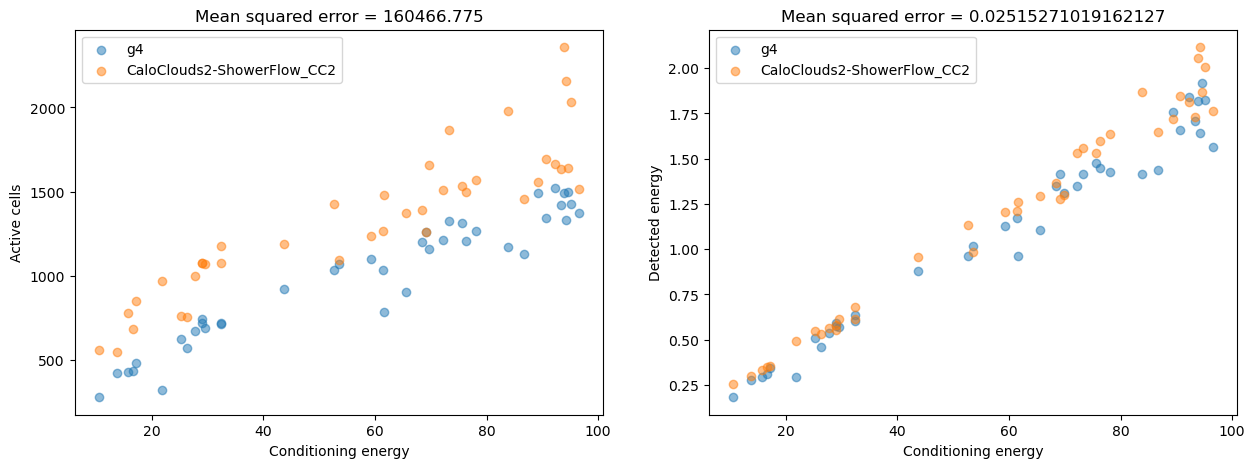

In [3]:

n_samples = 40
sample_n_coeff = np.zeros(4)
sample_n_coeff[-2] = 1.
plot_sample(dsf, model_name, n_samples, sample_n_coeff)

100%|██████████| 500/500 [00:05<00:00, 92.66it/s]


Text(0, 0.5, 'Number of active cells')

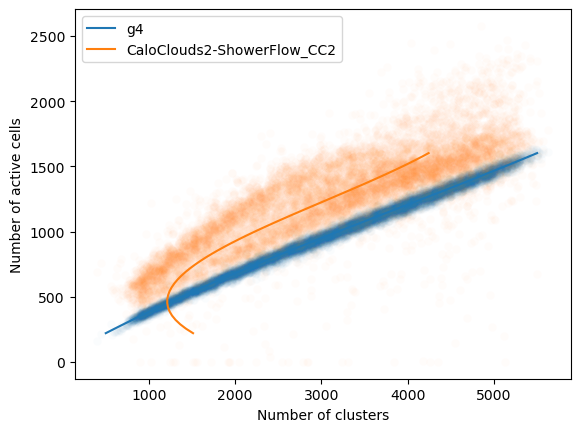

In [4]:

points = dsf.cond['points']

if hasattr(dsf, "real_coeff") and not redo:
    real_coeff = dsf.real_coeff
    fake_coeff = dsf.fake_coeff
    print("Previously calculated")
else:
    unit = np.zeros(2)
    unit[0] = 1.
    batch_size = 500
    total_events = len(dsf.cond['energy'])
    all_model_n, all_model_e = np.empty(total_events), np.empty(total_events)
    for batch_start in range(0, total_events, batch_size):
        batch_end = min(batch_size+batch_start, total_events)
        batch_idxs = list(range(batch_start, batch_end))
        n, e = dsf.model_events(batch_idxs, unit, None)
        all_model_n[batch_start:batch_end] = n
        all_model_e[batch_start:batch_end] = e
    real_coeff = np.polyfit(points.flatten(), dsf.g4_detector_n, 3)
    fake_coeff = np.polyfit(all_model_n, points.flatten(), 3)
    dsf.real_coeff = real_coeff
    dsf.fake_coeff = fake_coeff
    dsf.save(save_name)

from matplotlib import pyplot as plt
plt.scatter(points, dsf.g4_detector_n, alpha=0.02, lw=0)
xs = np.linspace(500, 5500)
ys = np.polyval(real_coeff, xs)
plt.plot(xs, np.polyval(real_coeff, xs), label="g4")
plt.scatter(points, all_model_n, alpha=0.02, lw=0)
plt.plot(np.polyval(fake_coeff, ys), ys, label=model_name)
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Number of active cells")

100%|██████████| 500/500 [00:05<00:00, 93.14it/s]


Text(0, 0.5, 'Number of active cells')

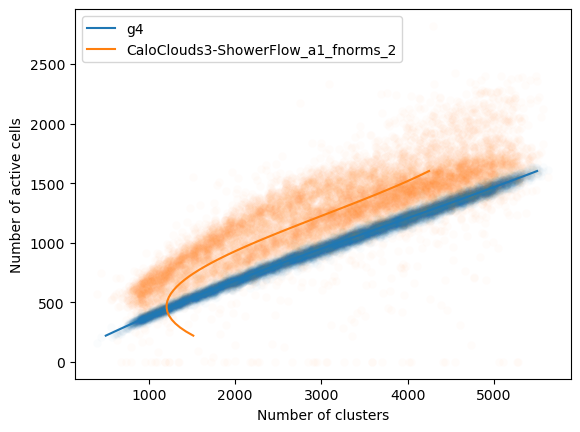

In [5]:

points_2 = dsf_2.cond['points']

if hasattr(dsf_2, "real_coeff") and not redo:
    real_coeff_2 = dsf_2.real_coeff
    fake_coeff_2 = dsf_2.fake_coeff
    print("Previously calculated")
else:
    unit = np.zeros(2)
    unit[0] = 1.
    batch_size = 500
    total_events_2 = len(dsf_2.cond['energy'])
    all_model_n_2, all_model_e_2 = np.empty(total_events_2), np.empty(total_events_2)
    for batch_start in range(0, total_events_2, batch_size):
        batch_end = min(batch_size+batch_start, total_events_2)
        batch_idxs = list(range(batch_start, batch_end))
        n, e = dsf_2.model_events(batch_idxs, unit, None)
        all_model_n_2[batch_start:batch_end] = n
        all_model_e_2[batch_start:batch_end] = e
    real_coeff_2 = np.polyfit(points_2.flatten(), dsf_2.g4_detector_n, 3)
    fake_coeff_2 = np.polyfit(all_model_n_2, points_2.flatten(), 3)
    dsf_2.real_coeff = real_coeff_2
    dsf_2.fake_coeff = fake_coeff_2
    dsf_2.save(save_name_2)

from matplotlib import pyplot as plt
plt.scatter(points_2, dsf_2.g4_detector_n, alpha=0.02, lw=0)
xs = np.linspace(500, 5500)
ys = np.polyval(real_coeff_2, xs)
plt.plot(xs, np.polyval(real_coeff_2, xs), label="g4")
plt.scatter(points_2, all_model_n_2, alpha=0.02, lw=0)
plt.plot(np.polyval(fake_coeff_2, ys), ys, label=model_name_2)
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Number of active cells")

100%|██████████| 100/100 [00:01<00:00, 88.18it/s]


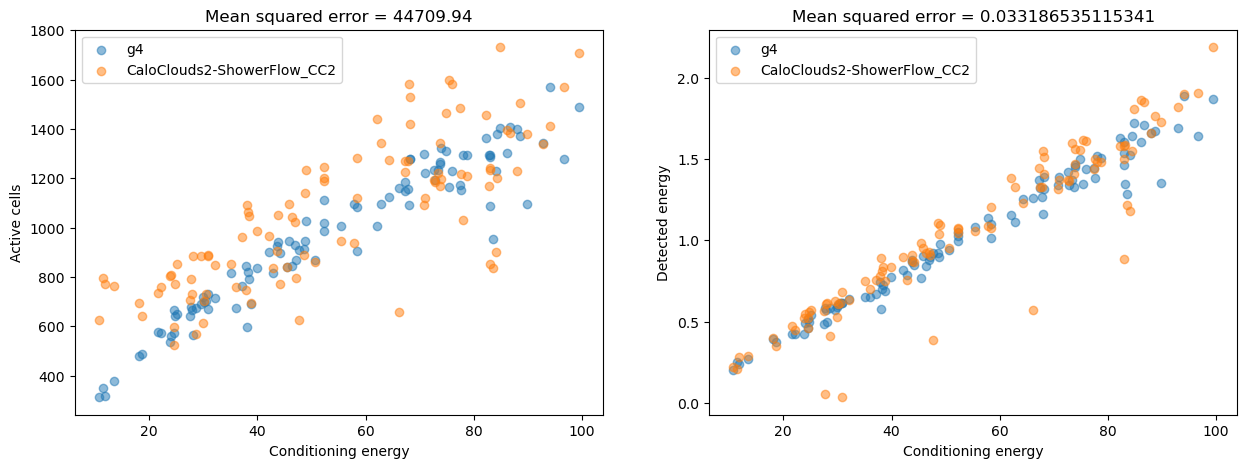

In [6]:
n_samples=100
plot_sample(dsf, model_name, n_samples, real_coeff, None, fake_coeff)

In [7]:

if hasattr(dsf, "final_e_coeff") and not redo:
    sample_e_coeff_1 = dsf.final_e_coeff
    print(f"Already done {sample_e_coeff_1}")
else:
    
    def to_minimise_1b(coeff_e):
        n_samples = 100
        sample_e_coeff = np.zeros(2, dtype=float)
        sample_e_coeff[0] = coeff_e
        mean_sq_n, mean_sq_e = dsf.divergance(n_samples, real_coeff, sample_e_coeff, fake_coeff)
        return mean_sq_e
    res_e_coeff_1 = minimize(to_minimise_1b, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1e-4})
    print(res_e_coeff_1)
    sample_e_coeff_1 = np.zeros(4)
    sample_e_coeff_1[-2] = res_e_coeff_1.x
    dsf.final_e_coeff = sample_e_coeff_1
    dsf.save(save_name)



100%|██████████| 100/100 [00:01<00:00, 98.94it/s]


Optimization terminated successfully.
         Current function value: 0.014365
         Iterations: 3
         Function evaluations: 119
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.014365023415941633
       x: [ 8.813e-01]
     nit: 3
   direc: [[ 5.007e-02]]
    nfev: 119


100%|██████████| 100/100 [00:01<00:00, 98.12it/s]


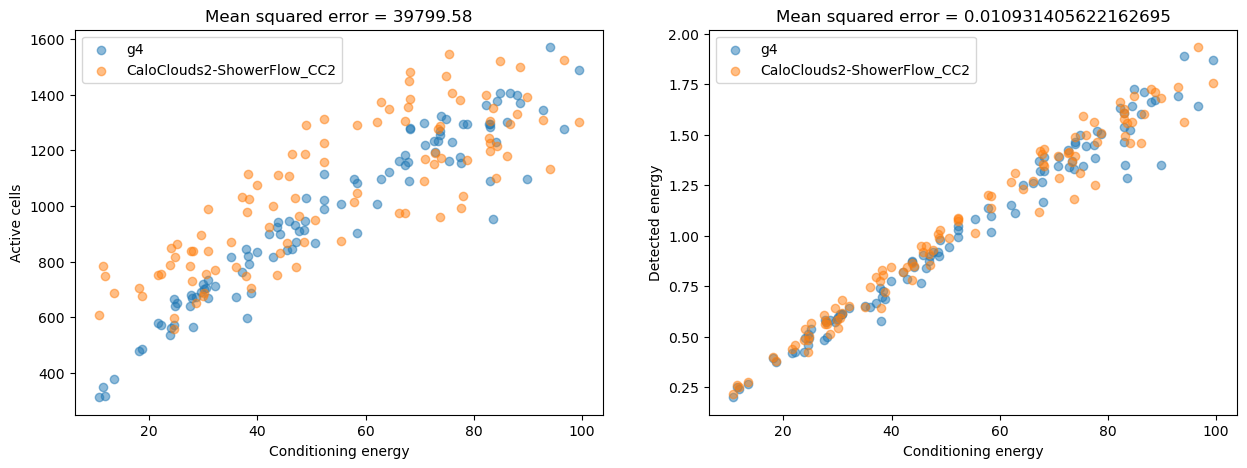

In [8]:
n_samples=100
plot_sample(dsf, model_name, n_samples, real_coeff, sample_e_coeff_1, fake_coeff)

100%|██████████| 100/100 [00:01<00:00, 89.67it/s]


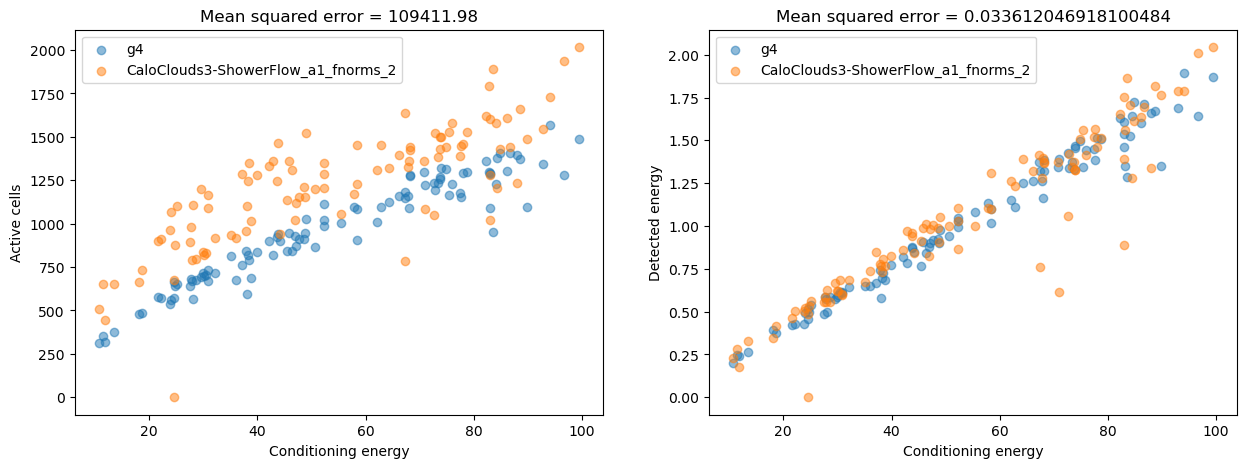

In [9]:

n_samples = 100
sample_n_coeff = np.zeros(4)
sample_n_coeff[-2] = 1.
plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff)

In [10]:


def to_minimise_2a(coeff_n):
    n_samples = 500
    sample_n_coeff = np.zeros(2, dtype=float)
    sample_n_coeff[:] = coeff_n
    mean_sq_n, mean_sq_e = dsf_2.divergance(n_samples, sample_n_coeff)
    idxs = dsf_2.cond_idxs
    g4_n = dsf_2.g4_detector_n[idxs]
    model_n = dsf_2.model_n
    weighted_distance = np.sum(np.abs(g4_n-model_n)/(g4_n+model_n))
    return weighted_distance


    

if hasattr(dsf_2, "final_n_coeff") and not redo:
    sample_n_coeff = dsf_2.final_n_coeff
    print(f"Already done {sample_n_coeff}")
else:
    x0 = np.zeros(2)
    x0[0] = 1.
    res_n_coeff_2 = minimize(to_minimise_2a, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1.})
    print(res_n_coeff_2)
    sample_n_coeff = np.zeros(2)
    sample_n_coeff[0] = res_n_coeff_2.x
    dsf_2.final_n_coeff = sample_n_coeff
    dsf_2.save(save_name_2)

100%|██████████| 500/500 [00:05<00:00, 96.70it/s]


Optimization terminated successfully.
         Current function value: 40.893171
         Iterations: 1
         Function evaluations: 29
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.89317095287784
       x: [ 5.454e-01]
     nit: 1
   direc: [[ 1.000e+00]]
    nfev: 29


100%|██████████| 100/100 [00:00<00:00, 100.80it/s]


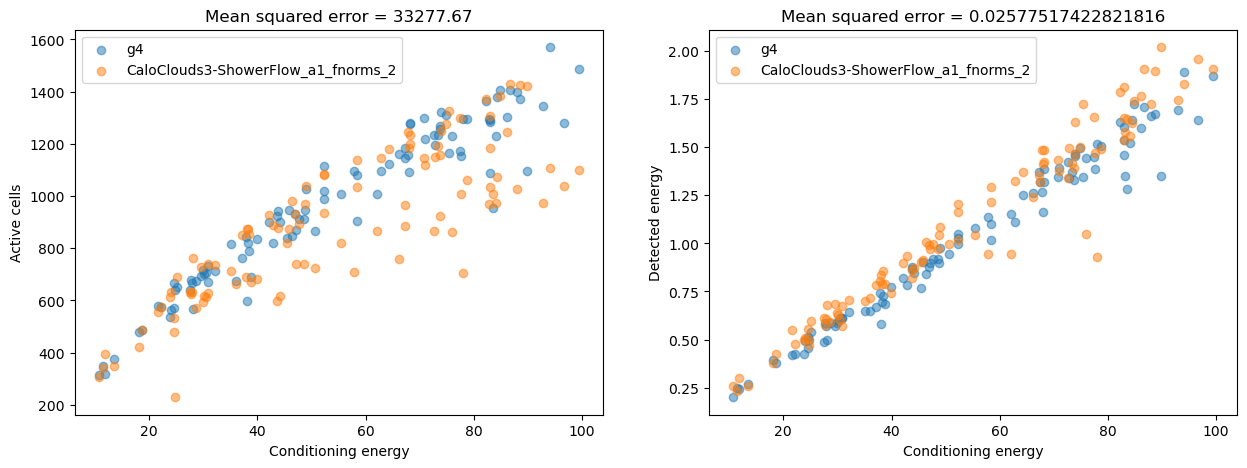

In [11]:
n_samples = 100

plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff)

In [12]:


def to_minimise_2b(coeff_e):
    n_samples = 500
    sample_n_coeff = np.zeros(2, dtype=float)
    sample_n_coeff[0] = res_n_coeff_2.x
    sample_e_coeff = np.zeros(2, dtype=float)
    sample_e_coeff[0] = coeff_e
    mean_sq_n, mean_sq_e = dsf_2.divergance(n_samples, sample_n_coeff, sample_e_coeff)
    idxs = dsf_2.cond_idxs
    g4_e = dsf_2.g4_detector_e[idxs]
    model_e = dsf_2.model_e
    weighted_distance = np.sum((g4_e-model_e)**2/(g4_e+model_e)**2)
    return weighted_distance


if hasattr(dsf_2, "final_e_coeff") and not redo:
    sample_e_coeff = dsf_2.final_e_coeff
    print(f"Already done {sample_e_coeff}")
else:
    x0 = np.zeros(2, dtype=float)
    res_e_coeff_2 = minimize(to_minimise_2b, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1e-4})
    print(res_e_coeff_2)
    sample_e_coeff = np.zeros(2)
    sample_e_coeff[0] = res_e_coeff_2.x
    dsf_2.final_e_coeff = sample_e_coeff
    dsf_2.save(save_name_2)



100%|██████████| 500/500 [00:05<00:00, 97.92it/s] 


Optimization terminated successfully.
         Current function value: 2.769608
         Iterations: 3
         Function evaluations: 65
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.7696083709279584
       x: [ 9.437e-01]
     nit: 3
   direc: [[ 1.000e+00]]
    nfev: 65


100%|██████████| 100/100 [00:01<00:00, 95.10it/s]


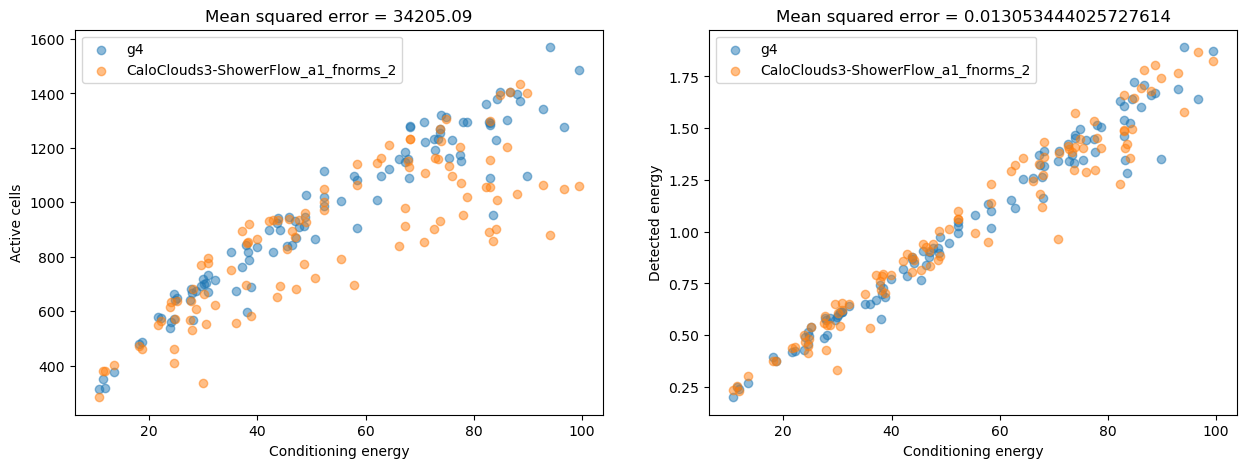

In [13]:
n_samples = 100
plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff, sample_e_coeff)

In [14]:
loaded = dict(np.load(save_name, allow_pickle=True))
loaded["real_coeff"] = real_coeff
loaded["fake_coeff"] = fake_coeff
loaded["final_e_coeff"] = sample_e_coeff_1
np.savez(save_name, **loaded)


In [15]:
loaded = dict(np.load(save_name_2, allow_pickle=True))
loaded["final_n_coeff"] = sample_n_coeff
loaded["final_e_coeff"] = sample_e_coeff
np.savez(save_name_2, **loaded)

In [16]:
real_coeff

array([ 2.55948436e-09, -2.92628801e-05,  3.66813614e-01,  4.41188358e+01])

In [17]:
fake_coeff


array([-1.53255123e-06,  5.80748578e-03, -3.94733624e+00,  1.92346697e+03])

In [18]:
model_name_2


'CaloClouds3-ShowerFlow_a1_fnorms_2'

In [19]:
sample_e_coeff_1

array([0.        , 0.        , 0.97049687, 0.        ])

In [20]:
sample_e_coeff

array([0.94373119, 0.        ])

In [21]:
sample_n_coeff

array([0.54535075, 0.        ])